In [1]:
%matplotlib inline

import itertools
from collections import Counter

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


import pymongo

In [2]:
client = pymongo.MongoClient()
fields = ['title', 'year', 'type', 'metascore', 'genre']
cursor = client.movies_db.movies_collection.find({})

# Get all movies from the collection
movies_df = pd.DataFrame(list(cursor), columns=fields)

In [3]:
from IPython.display import display, HTML
display(movies_df.head())
display(movies_df.tail())

,title,year,type,metascore,genre
0,Carmencita,1894,movie,N/A,"Documentary, Short"
1,Le clown et ses chiens,1892,movie,N/A,"Animation, Short"
2,Pauvre Pierrot,1892,movie,N/A,"Animation, Comedy, Short"
3,Un bon bock,1892,movie,N/A,"Animation, Short"
4,Blacksmith Scene,1893,movie,N/A,Short


,title,year,type,metascore,genre
566292,Don't Ever Speak to Me Again,1966,episode,N/A,"Comedy, War, Western"
566293,Episode #1.11,1952,episode,N/A,N/A
566294,Wings,2005,episode,N/A,"Crime, Drama, Mystery"
566295,Dirge for the Scourge,1965,episode,N/A,"Comedy, War, Western"
566296,"Don't Look Now, One of Our Cannon Is Missing",1965,episode,N/A,"Comedy, War, Western"


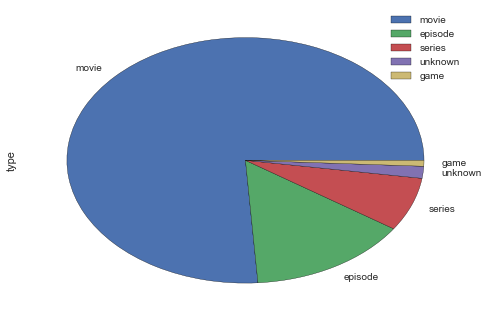

In [4]:
# What types of movies do we have
movies_df['type'].unique()

type_series = movies_df['type']
type_series = type_series.replace('', 'unknown')

type_series.value_counts().plot(kind='pie', legend='True')

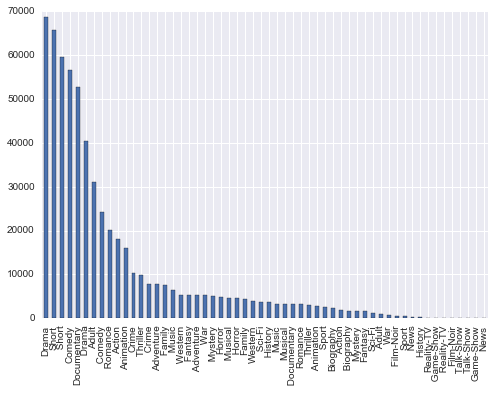

In [5]:
movies = movies_df[movies_df['type'] == 'movie']

movies_with_genres = movies.copy()[(movies['genre'] != 'N/A') & (movies['genre'] != '')]


df = movies_with_genres[['year', 'genre']]

genres = pd.DataFrame(df.genre.str.split(',').tolist(), index=df.year).stack()
genres = genres.reset_index()[[0, 'year']] # var1 variable is currently labeled 0
genres.columns = ['genre', 'date'] # renaming var1
genres

genres['genre'].value_counts().plot(kind='bar')

In [6]:
# Convert strings date column to time series
genres['date'] = pd.to_datetime(genres['date'])
# genres.set_index(['date'], inplace=True)
genres.tail()

,genre,date
595627,Sci-Fi,2004-01-01
595628,Family,1971-01-01
595629,Adventure,2006-01-01
595630,Comedy,2006-01-01
595631,Crime,2006-01-01


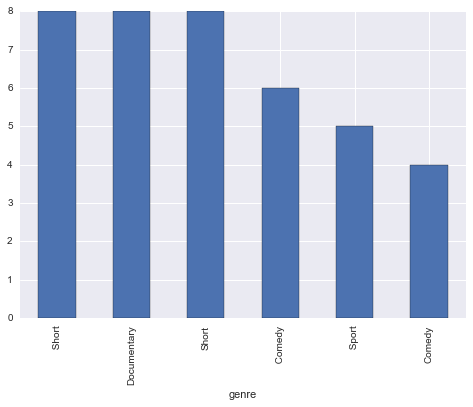

In [110]:
genres_by_decades = genres.groupby('date')['genre'].value_counts().unstack().resample('10AS').count()
t = genres_by_decades.transpose()
t['1888-01-01 '].nlargest(6).plot(kind='bar', stacked=True)

In [ ]:
t['1888-01-01 '].nlargest(6).plot